In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:

from tensorflow.keras.applications import Xception

pre_model = Xception(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = 'imagenet')

# Make all the layers in the pre-model non-trainable
for layer in pre_model.layers:
    layer.trainable = False

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
pre_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:

last_layer = pre_model.get_layer('block14_sepconv2_bn')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 2048)


In [ ]:
loss = 'mean_squared_error'
metrics = ['mse','mae']
batch_size=64
epochs = 10

In [ ]:
from tensorflow.keras.optimizers import Adam

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.4
x = layers.Dropout(0.4)(x)                  
# Add a final linear layer for classification
x = layers.Dense  (1, activation='linear')(x) 
model = Model(pre_model.input, x)

model.compile(optimizer = tf.keras.optimizers.Adam(0.01), 
              loss = 'mean_squared_error',
              metrics = metrics) 

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [ ]:
raw_dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SDSS.csv")
train_df = raw_dataset.copy()
train_df

,img_path,z
0,/content/drive/MyDrive/Colab Notebooks/galaxy_...,0.037450
1,/content/drive/MyDrive/Colab Notebooks/galaxy_...,-99.990000
2,/content/drive/MyDrive/Colab Notebooks/galaxy_...,0.029610
3,/content/drive/MyDrive/Colab Notebooks/galaxy_...,0.002882
4,/content/drive/MyDrive/Colab Notebooks/galaxy_...,0.038340
...,...,...
4453,/content/drive/MyDrive/Colab Notebooks/galaxy_...,-100.000000
4454,/content/drive/MyDrive/Colab Notebooks/galaxy_...,-99.990000
4455,/content/drive/MyDrive/Colab Notebooks/galaxy_...,0.024300
4456,/content/drive/MyDrive/Colab Notebooks/galaxy_...,0.022220


In [ ]:
import numpy as np
cnt=0
for row in train_df['z']:
    try:
        if row==-99.990000 or row==-100.000000 :
          train_df.loc[cnt, 'z']=np.nan
    except ValueError:
        pass
    cnt+=1

In [ ]:
train_df.isna().sum()

img_path       0
z           1357
dtype: int64

In [ ]:
# median = train_df['z'].median()
# train_df['z'].fillna(median, inplace=True)
train_df = train_df.dropna()

In [ ]:
train_df.isna().sum()

img_path    0
z           0
dtype: int64

In [ ]:
dataset=train_df.copy()

In [ ]:
train_df = dataset.sample(frac=0.8, random_state=0)
test_df = dataset.drop(train_df.index)

In [ ]:
datagen = ImageDataGenerator( 
            rescale=1./255.,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            validation_split=0.30,
            fill_mode='nearest')

train_generator=datagen.flow_from_dataframe(
            dataframe=train_df,
            directory=None,
            x_col="img_path",
            y_col="z",
            subset="training",
            batch_size=32,
            seed=42,
            shuffle=True,
            class_mode="other",
            target_size=(224,224))

valid_generator=datagen.flow_from_dataframe(
            dataframe=train_df,
            directory=None,
            x_col="img_path",
            y_col="z",
            subset="validation",
            batch_size=32,
            seed=42,
            class_mode="other",
            target_size=(224,224))

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory=None,
            x_col="img_path",
            y_col=None,
            batch_size=batch_size,
            seed=42,
            class_mode=None,
            target_size=(224,224))           

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.6/logging/__init__.py", line 994, in emit
    msg = self.format(record)
  File "/usr/lib/python3.6/logging/__init__.py", line 840, in format
    return fmt.format(record)
  File "/usr/lib/python3.6/logging/__init__.py", line 577, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.6/logging/__init__.py", line 338, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/usr/local/lib/python

Found 1737 validated image filenames.


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.6/logging/__init__.py", line 994, in emit
    msg = self.format(record)
  File "/usr/lib/python3.6/logging/__init__.py", line 840, in format
    return fmt.format(record)
  File "/usr/lib/python3.6/logging/__init__.py", line 577, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.6/logging/__init__.py", line 338, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/usr/local/lib/python

Found 744 validated image filenames.
Found 620 validated image filenames.


In [ ]:
from keras.callbacks import EarlyStopping
earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='auto')

# class myCallback(tf.keras.callbacks.Callback): 
#     def on_epoch_end(self, epoch, logs={}): 
#         if(logs.get('loss') < 0.001):   
#           print("\nReached %2.2f%% loss, so stopping training!!" %(0.001*100))   
#           self.model.stop_training = True

# callbacks = myCallback()

In [ ]:
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=10,
                    steps_per_epoch=10,
                    verbose=1,
                    callbacks=[earlystopper])

Epoch 1/10
10/10 [==============================] - 299s 30s/step - loss: 10416390.0000 - mse: 10416390.0000 - mae: 2009.7539 - val_loss: 1447294.6250 - val_mse: 1447294.6250 - val_mae: 1163.9724
Epoch 2/10
10/10 [==============================] - 229s 23s/step - loss: 599737.6250 - mse: 599737.6250 - mae: 607.2131 - val_loss: 32902.3945 - val_mse: 32902.3945 - val_mae: 166.4462
Epoch 3/10
10/10 [==============================] - 224s 22s/step - loss: 104808.2656 - mse: 104808.2656 - mae: 252.3694 - val_loss: 2707.2859 - val_mse: 2707.2859 - val_mae: 42.1847
Epoch 4/10
10/10 [==============================] - 223s 22s/step - loss: 34753.2422 - mse: 34753.2422 - mae: 146.8468 - val_loss: 2597.3608 - val_mse: 2597.3608 - val_mae: 40.7551
Epoch 5/10
10/10 [==============================] - 224s 22s/step - loss: 16487.6094 - mse: 16487.6094 - mae: 98.9301 - val_loss: 1552.6736 - val_mse: 1552.6736 - val_mae: 31.9748
Epoch 6/10
10/10 [==============================] - 221s 22s/step - loss: 

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mse,mae,val_loss,val_mse,val_mae,epoch
0,1.041639e+07,1.041639e+07,2009.753906,1.447295e+06,1.447295e+06,1163.972412,0
1,5.997376e+05,5.997376e+05,607.213135,3.290239e+04,3.290239e+04,166.446243,1
2,1.048083e+05,1.048083e+05,252.369385,2.707286e+03,2.707286e+03,42.184658,2
3,3.475324e+04,3.475324e+04,146.846756,2.597361e+03,2.597361e+03,40.755081,3
4,1.648761e+04,1.648761e+04,98.930069,1.552674e+03,1.552674e+03,31.974754,4
5,9.699811e+03,9.699811e+03,76.212463,7.145677e+02,7.145677e+02,21.158014,5
6,6.889460e+03,6.889460e+03,63.365643,3.948726e+02,3.948726e+02,16.003130,6
7,5.221624e+03,5.221624e+03,56.179768,4.333825e+02,4.333825e+02,16.563465,7
8,3.918962e+03,3.918962e+03,49.463356,2.418954e+02,2.418954e+02,12.338145,8
9,3.402862e+03,3.402862e+03,44.607777,1.915743e+02,1.915743e+02,11.126908,9


In [ ]:

import matplotlib.pyplot as plt
%matplotlib inline
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [z]')
  plt.legend()
  plt.grid(True)

  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Err [z]')
  plt.plot(hist['epoch'], hist['mae'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Squared Err [$z^2$]')
  plt.plot(hist['epoch'], hist['mse'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
  plt.legend()



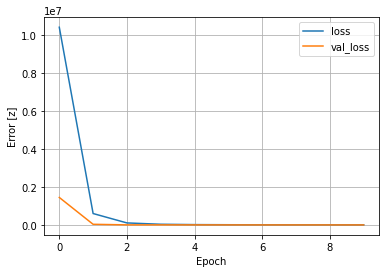

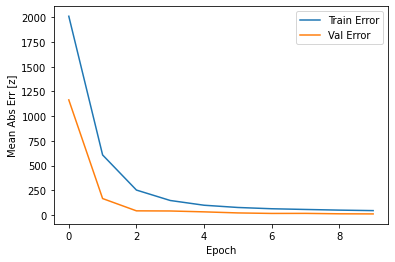

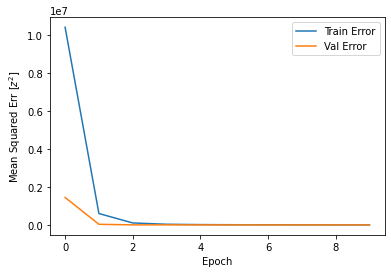

In [ ]:
plot_loss(history)

In [ ]:
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=15,
                    steps_per_epoch=10,
                    verbose=1,
                    callbacks=[earlystopper])

Epoch 1/15
10/10 [==============================] - 225s 23s/step - loss: 2438.1497 - mse: 2438.1497 - mae: 39.5819 - val_loss: 182.3074 - val_mse: 182.3074 - val_mae: 11.0521
Epoch 2/15
10/10 [==============================] - 228s 23s/step - loss: 2128.3511 - mse: 2128.3511 - mae: 35.7115 - val_loss: 128.7862 - val_mse: 128.7862 - val_mae: 8.9691
Epoch 3/15
10/10 [==============================] - 228s 23s/step - loss: 2080.2568 - mse: 2080.2568 - mae: 34.6427 - val_loss: 136.2563 - val_mse: 136.2563 - val_mae: 9.1002
Epoch 4/15
10/10 [==============================] - 228s 23s/step - loss: 1327.1567 - mse: 1327.1567 - mae: 28.3323 - val_loss: 86.5611 - val_mse: 86.5611 - val_mae: 7.4591
Epoch 5/15
10/10 [==============================] - 221s 22s/step - loss: 1094.8104 - mse: 1094.8104 - mae: 26.1554 - val_loss: 74.3001 - val_mse: 74.3001 - val_mae: 6.7474
Epoch 6/15
10/10 [==============================] - 226s 23s/step - loss: 1069.6465 - mse: 1069.6465 - mae: 24.6429 - val_loss: 

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mse,mae,val_loss,val_mse,val_mae,epoch
0,2438.149658,2438.149658,39.581921,182.307358,182.307358,11.052090,0
1,2128.351074,2128.351074,35.711452,128.786194,128.786194,8.969119,1
2,2080.256836,2080.256836,34.642673,136.256317,136.256317,9.100198,2
3,1327.156738,1327.156738,28.332281,86.561142,86.561142,7.459116,3
4,1094.810425,1094.810425,26.155382,74.300079,74.300079,6.747367,4
5,1069.646484,1069.646484,24.642870,69.961517,69.961517,6.636754,5
6,929.523315,929.523315,23.568010,60.147617,60.147617,6.030286,6
7,641.034241,641.034241,19.342781,48.301746,48.301746,5.469063,7
8,691.652710,691.652710,20.373083,48.894402,48.894402,5.611617,8
9,531.637390,531.637390,17.586561,44.206951,44.206951,5.353971,9


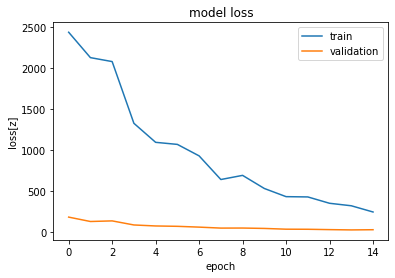

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss[z]')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

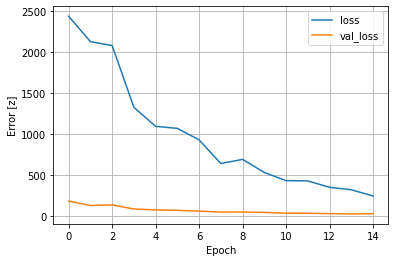

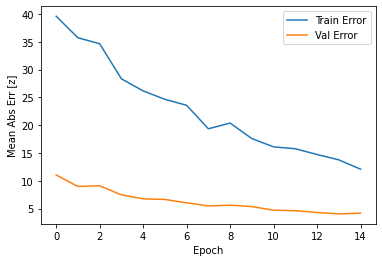

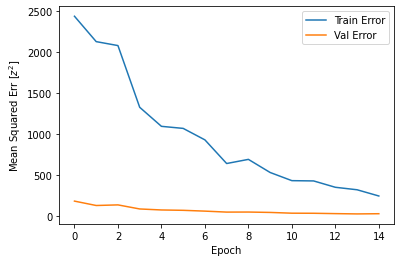

In [ ]:
plot_loss(history)

In [ ]:
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=25,
                    steps_per_epoch=10,
                    verbose=1,
                    callbacks=[earlystopper])

Epoch 1/25
10/10 [==============================] - 224s 22s/step - loss: 263.6210 - mse: 263.6210 - mae: 12.4571 - val_loss: 21.4055 - val_mse: 21.4055 - val_mae: 3.6604
Epoch 2/25
10/10 [==============================] - 224s 22s/step - loss: 265.1759 - mse: 265.1759 - mae: 12.2956 - val_loss: 21.0278 - val_mse: 21.0278 - val_mae: 3.5574
Epoch 3/25
10/10 [==============================] - 225s 23s/step - loss: 166.0170 - mse: 166.0170 - mae: 10.0111 - val_loss: 19.9664 - val_mse: 19.9664 - val_mae: 3.4311
Epoch 4/25
10/10 [==============================] - 227s 23s/step - loss: 187.2534 - mse: 187.2534 - mae: 10.6414 - val_loss: 18.8779 - val_mse: 18.8779 - val_mae: 3.4077
Epoch 5/25
10/10 [==============================] - 227s 23s/step - loss: 146.0546 - mse: 146.0546 - mae: 9.0098 - val_loss: 15.8722 - val_mse: 15.8722 - val_mae: 3.1259
Epoch 6/25
10/10 [==============================] - 227s 23s/step - loss: 133.2333 - mse: 133.2333 - mae: 8.5505 - val_loss: 14.3588 - val_mse: 14

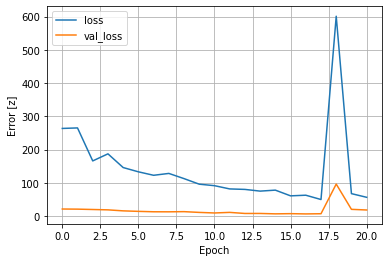

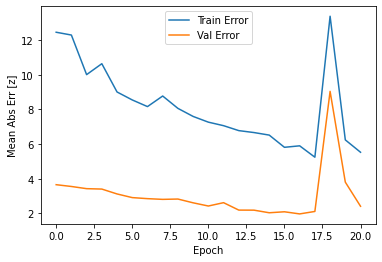

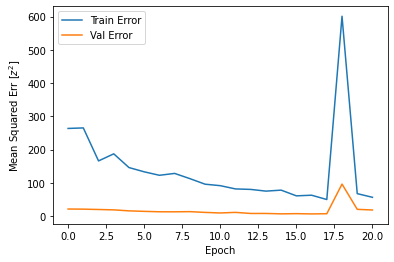

In [ ]:
plot_loss(history)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mse,mae,val_loss,val_mse,val_mae,epoch
0,263.621002,263.621002,12.457067,21.405540,21.405540,3.660366,0
1,265.175934,265.175934,12.295640,21.027826,21.027826,3.557410,1
2,166.016983,166.016983,10.011065,19.966381,19.966381,3.431075,2
3,187.253448,187.253448,10.641391,18.877909,18.877909,3.407731,3
4,146.054626,146.054626,9.009787,15.872240,15.872240,3.125922,4
5,133.233337,133.233337,8.550505,14.358803,14.358803,2.915141,5
6,122.804443,122.804443,8.166742,13.120137,13.120137,2.854777,6
7,128.405823,128.405823,8.776960,12.999134,12.999134,2.813386,7
8,112.785789,112.785789,8.063802,13.504698,13.504698,2.832143,8
9,96.049606,96.049606,7.598619,11.220321,11.220321,2.614384,9


In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/Zmodel_Xception")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Zmodel_Xception/assets


In [ ]:
test_features = test_df.copy()
test_labels = test_features.pop('z')

In [ ]:
test_predictions = model.predict(test_generator)


In [ ]:
test_predictions

array([[-2.57724094e+00],
       [-1.18985879e+00],
       [-8.05853248e-01],
       [-3.68918538e+00],
       [-3.06802535e+00],
       [-3.70432287e-01],
       [-2.30372858e+00],
       [-4.17818594e+00],
       [ 3.33691835e+00],
       [-1.75443828e+00],
       [-8.48092079e-01],
       [-8.19261432e-01],
       [ 4.09628004e-02],
       [ 5.28632522e-01],
       [ 1.68232727e+01],
       [ 8.02046895e-01],
       [-2.62339258e+00],
       [-4.43110847e+00],
       [-2.06085205e+00],
       [-7.43397331e+00],
       [-2.93073225e+00],
       [ 9.67541784e-02],
       [-4.82662112e-01],
       [-3.57969671e-01],
       [ 3.39914650e-01],
       [-4.00079584e+00],
       [-4.48807526e+00],
       [-3.26437569e+00],
       [-2.70704269e+00],
       [-4.26981837e-01],
       [-1.26112735e+00],
       [-3.45353413e+00],
       [-1.81489909e+00],
       [-6.49618483e+00],
       [ 2.01692619e+01],
       [-1.69186866e+00],
       [-1.83472002e+00],
       [-2.23804474e+00],
       [-8.6

In [ ]:
np.save('/content/drive/MyDrive/Colab Notebooks/Xceptionpredictions', test_predictions)

In [ ]:
result={}

In [ ]:
result['Predicted'] = test_predictions

In [ ]:
result['z'] = np.array (test_labels)

In [ ]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(y_true = result['z'], y_pred = result['Predicted'])
RMSE = MSE**(0.5)

In [ ]:
print(MSE)
print(RMSE)

16.607033911117473
4.075172868863047


In [ ]:
result['Predicted']=test_predictions.flatten()

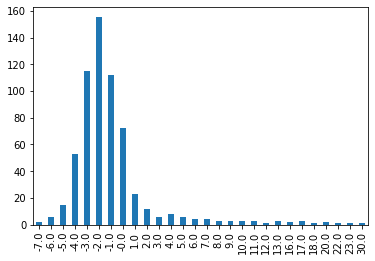

In [ ]:
fig1 = plt.gcf()
pd.value_counts(result['Predicted'].round(0)).sort_index().plot(kind="bar")

In [ ]:
test_predictions = np.load('/content/drive/MyDrive/Colab Notebooks/Xceptionpredictions.npy')

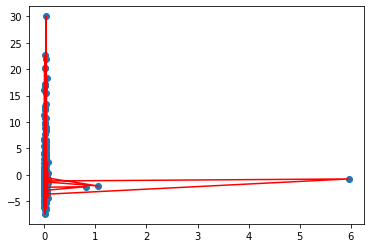

In [ ]:
plt.scatter(test_labels, test_predictions)
plt.plot(test_labels, test_predictions, c='red')

In [ ]:
spec=test_labels.to_numpy()
outlier=(spec-test_predictions)/(1+spec)
outlier

array([[2.5203055 , 2.51900239, 1.22684323, ..., 2.53067773, 2.55485109,
        2.53581988],
       [1.18300525, 1.18284839, 1.02730603, ..., 1.18425379, 1.18716364,
        1.18487278],
       [0.81286158, 0.81302198, 0.97207727, ..., 0.81158484, 0.80860927,
        0.81095188],
       ...,
       [1.73442471, 1.73379521, 1.10958276, ..., 1.73943529, 1.75111289,
        1.74191935],
       [0.05139983, 0.05221292, 0.85846034, ..., 0.04492805, 0.02984499,
        0.04171958],
       [2.27908276, 2.27798641, 1.19085063, ..., 2.28780925, 2.30814709,
        2.29213551]])

In [ ]:
f=pd.DataFrame(outlier)
f[0].median()

1.6760335886666295

In [ ]:
f[0].mean()

0.8737840545564263